#**BICYCLE LANE DISTRIBUTION ANALYSIS**

In [7]:
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


**Loading the GeoJSON file containing Bicycle path data :**

In [9]:
# Load the GeoJSON file containing park data
Bicycle_lane = gpd.read_file('/content/amsterdam.geojson')
boundary = gpd.read_file("/content/Province_Boundary.geojson")

In [10]:
Bicycle_lane.head()

,id,@id,abandoned:railway,access,access:conditional,agricultural,alt_name,architect,asphalt,bicycle,...,two_sided,usage,waterway,wheelchair,width,wikidata,wikimedia_commons,wikipedia,zone:traffic,geometry
0,way/4264947,way/4264947,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.92236 52.36544, 4.92237 52.36543..."
1,way/4270806,way/4270806,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.93089 52.36596, 4.93090 52.36585..."
2,way/4305753,way/4305753,None,None,None,None,None,None,None,None,...,None,None,None,None,6.00,None,None,None,None,"LINESTRING (4.86787 52.32198, 4.86787 52.32192)"
3,way/4363637,way/4363637,None,None,None,None,None,None,None,None,...,None,None,None,None,2.40,None,None,None,None,"LINESTRING (4.91538 52.37115, 4.91544 52.37118..."
4,way/4364612,way/4364612,None,yes,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.92291 52.37384, 4.92291 52.37389..."


In [11]:
Bicycle_lane.columns

Index(['id', '@id', 'abandoned:railway', 'access', 'access:conditional',
       'agricultural', 'alt_name', 'architect', 'asphalt', 'bicycle',
       ...
       'two_sided', 'usage', 'waterway', 'wheelchair', 'width', 'wikidata',
       'wikimedia_commons', 'wikipedia', 'zone:traffic', 'geometry'],
      dtype='object', length=155)

In [12]:
print("Bicycle Lane DataFrame Info:")
print(Bicycle_lane.info())

Bicycle Lane DataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8445 entries, 0 to 8444
Columns: 155 entries, id to geometry
dtypes: geometry(1), object(154)
memory usage: 10.0+ MB
None


In [13]:
boundary.head()

,id,@id,FIXME,abandoned:railway,access,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,...,traffic_sign:forward,tunnel,type,website,width,wikidata,wikimedia_commons,wikipedia,zone:traffic,geometry
0,way/4371188,way/4371188,None,None,None,None,None,None,None,None,...,None,None,None,None,5,None,None,None,None,"LINESTRING (4.90994 52.38307, 4.90994 52.38306..."
1,way/4727071,way/4727071,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.97510 52.35663, 4.97522 52.35667..."
2,way/4785569,way/4785569,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.82644 52.24049, 4.82639 52.24047..."
3,way/4835726,way/4835726,None,None,None,None,None,None,None,None,...,None,None,None,None,3.25,None,None,None,None,"LINESTRING (4.91301 52.38664, 4.91305 52.38663..."
4,way/4871314,way/4871314,None,None,None,None,None,None,None,None,...,None,None,None,None,3,None,None,None,None,"LINESTRING (4.96241 52.33261, 4.96232 52.33262..."


In [14]:
boundary.columns

Index(['id', '@id', 'FIXME', 'abandoned:railway', 'access', 'addr:city',
       'addr:country', 'addr:housenumber', 'addr:postcode', 'addr:street',
       ...
       'traffic_sign:forward', 'tunnel', 'type', 'website', 'width',
       'wikidata', 'wikimedia_commons', 'wikipedia', 'zone:traffic',
       'geometry'],
      dtype='object', length=143)

In [16]:
print("\nBoundary DataFrame Info:")
print(boundary.info())


Boundary DataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Columns: 143 entries, id to geometry
dtypes: geometry(1), object(142)
memory usage: 3.5+ MB
None


**Plotting and cleaning the data :**

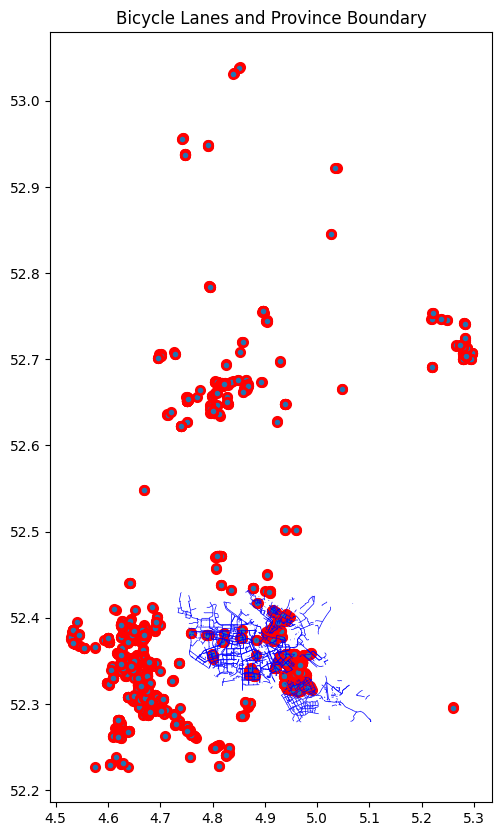

In [15]:
# Plot bicycle lanes
fig, ax = plt.subplots(figsize=(10, 10))
Bicycle_lane.plot(ax=ax, color='blue', linewidth=0.5, edgecolor='black')
boundary.boundary.plot(ax=ax, color=None, linewidth=2, edgecolor='red')
ax.set_title('Bicycle Lanes and Province Boundary')
plt.show()


In [17]:
# Check unique values in the 'bicycle' column of Bicycle_lane
print("Unique values in 'bicycle' column of Bicycle_lane:")
print(Bicycle_lane['bicycle'].unique())




Unique values in 'bicycle' column of Bicycle_lane:
[None 'designated' 'permissive' 'yes' 'dismount' 'no']


**Filter bicycle lanes with designated access :**

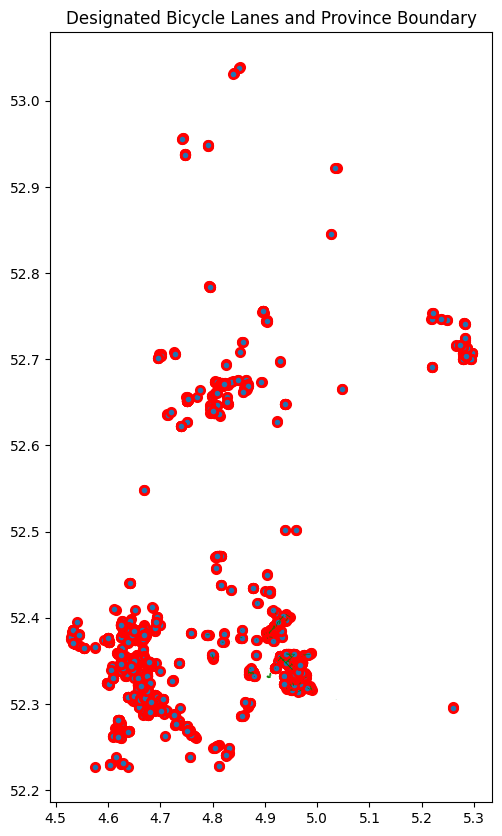

In [18]:
designated_bicycle_lanes = Bicycle_lane[Bicycle_lane['bicycle'] == 'designated']

# Plot designated bicycle lanes
fig, ax = plt.subplots(figsize=(10, 10))
designated_bicycle_lanes.plot(ax=ax, color='green', linewidth=0.5, edgecolor='black')
boundary.boundary.plot(ax=ax, color=None, linewidth=2, edgecolor='red')
ax.set_title('Designated Bicycle Lanes and Province Boundary')
plt.show()

**Path analysis**

In [22]:
# Check unique values in the 'surface' column
unique_surface_types = Bicycle_lane['surface'].unique()
print("Unique surface types:", unique_surface_types)

# Print summary statistics
surface_stats = Bicycle_lane['surface'].value_counts()
print("\nSurface Type Statistics:")
print(surface_stats)

Unique surface types: ['asphalt' 'paving_stones' 'wood' None 'paved' 'concrete' 'fine_gravel'
 'pebblestone' 'metal' 'sett' 'concrete:plates' 'sand' 'red' 'cobblestone']

Surface Type Statistics:
asphalt            4644
paving_stones      1501
paved               126
concrete             40
wood                 37
fine_gravel          32
red                   3
pebblestone           2
metal                 2
cobblestone           2
sett                  1
concrete:plates       1
sand                  1
Name: surface, dtype: int64


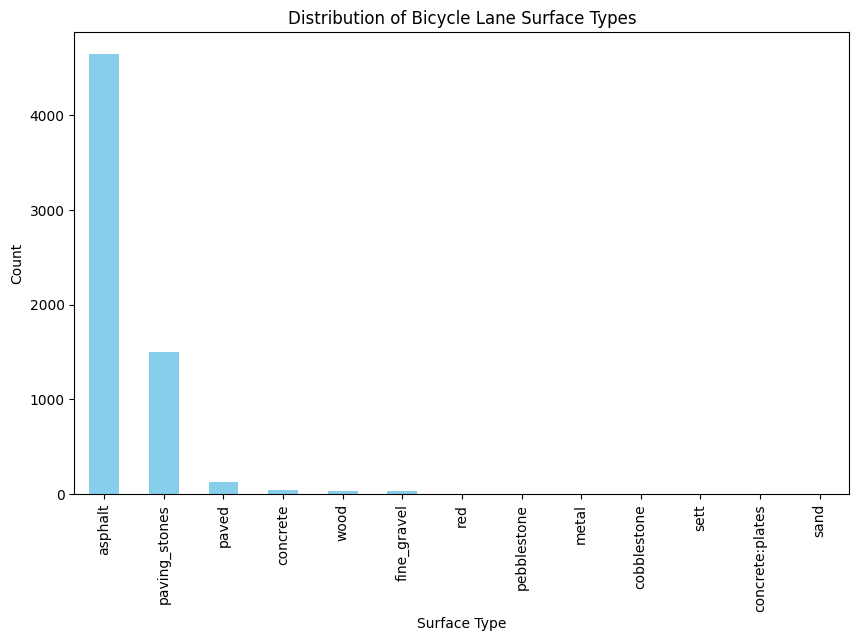

In [62]:
surface_distribution = Bicycle_lane['surface'].value_counts()

# Plot the distribution of surface types
plt.figure(figsize=(10, 6))
surface_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Bicycle Lane Surface Types')
plt.xlabel('Surface Type')
plt.ylabel('Count')
plt.show()

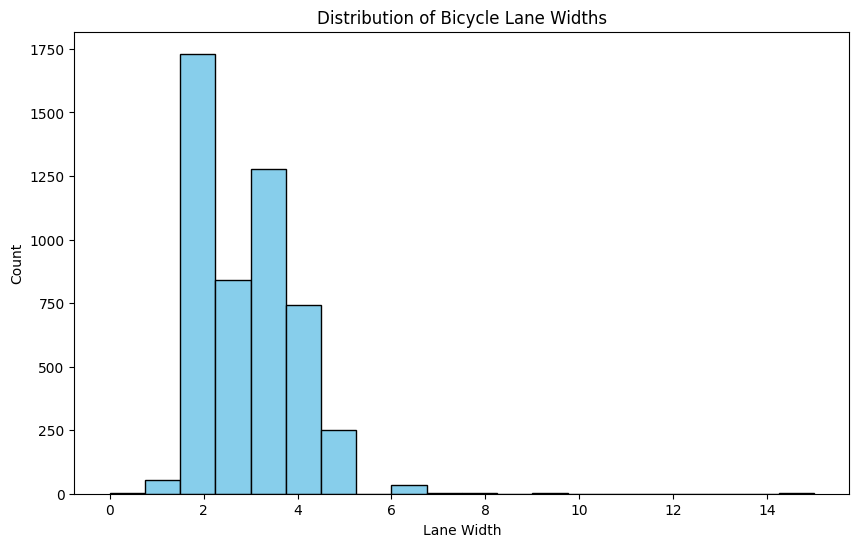

Maximum width of the path :


15.0

In [24]:
# Converting 'width' to numeric, replacing non-numeric values with NaN
Bicycle_lane['width'] = pd.to_numeric(Bicycle_lane['width'], errors='coerce')

plt.figure(figsize=(10, 6))
Bicycle_lane['width'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Bicycle Lane Widths')
plt.xlabel('Lane Width')
plt.ylabel('Count')
plt.show()

print("Maximum width of the path :")
Bicycle_lane['width'].max()



We infer that maximum amount of paths are of width **2 meters**.

**Durability anlaysis :**

In [25]:
Bicycle_lane['width'] = pd.to_numeric(Bicycle_lane['width'], errors='coerce')

# Assess durability based on hypothetical criteria
Bicycle_lane['durability'] = 'Unknown'
Bicycle_lane.loc[Bicycle_lane['surface'] == 'asphalt', 'durability'] = 'High'
Bicycle_lane.loc[Bicycle_lane['width'] >= 2.0, 'durability'] = 'High'
Bicycle_lane.loc[(Bicycle_lane['surface'] == 'concrete') & (Bicycle_lane['width'] >= 2.0), 'durability'] = 'High'
Bicycle_lane.loc[(Bicycle_lane['surface'] == 'concrete') & (Bicycle_lane['width'] < 2.0), 'durability'] = 'Medium'
Bicycle_lane.loc[Bicycle_lane['surface'] == 'gravel', 'durability'] = 'Low'

# Print statistics
durability_stats = Bicycle_lane['durability'].value_counts()
print("\nDurability Statistics for Bicycle Lanes:")
print(durability_stats)


Durability Statistics for Bicycle Lanes:
High       5747
Unknown    2692
Medium        6
Name: durability, dtype: int64



Correlation Matrix:
                 surface  safety_concerns
surface              1.0              NaN
safety_concerns      NaN              NaN


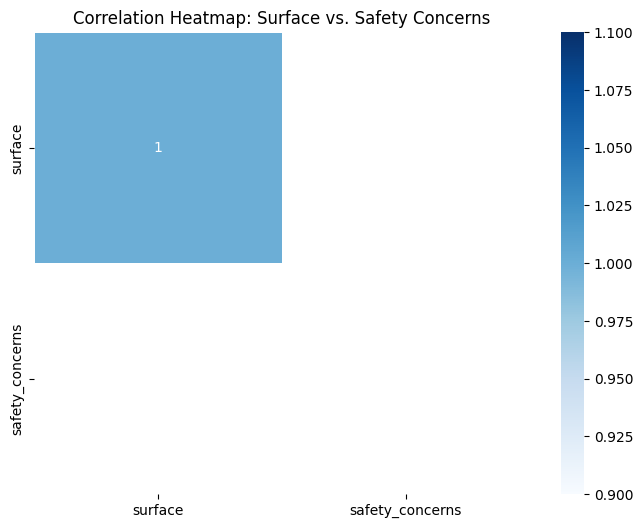

In [27]:
# Hypothetical: Assign safety_concerns values based on some criteria
Bicycle_lane['safety_concerns'] = 'Low'
Bicycle_lane.loc[Bicycle_lane['surface'] == 'asphalt', 'safety_concerns'] = 'Low'  # Adjust based on actual safety data

# Print correlation matrix
correlation_matrix = Bicycle_lane[['surface', 'safety_concerns']].apply(lambda x: pd.factorize(x)[0]).corr(method='pearson')
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation with a single color
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=.5)  # Use 'Blues' colormap for a single color
plt.title('Correlation Heatmap: Surface vs. Safety Concerns')
plt.show()


Inference:
Safety concerns are **more correlated** with the surface of the paths and
most preferable path are with good surfaces.

**Spatial Connectivity:**

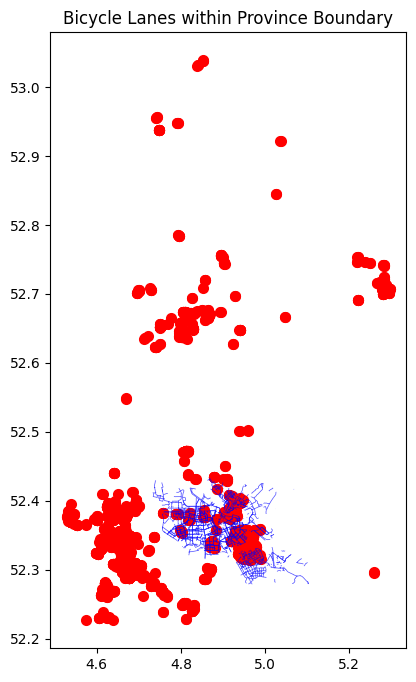

In [36]:
# Plot bicycle lanes within the province boundary
fig, ax = plt.subplots(figsize=(12, 8))
boundary.boundary.plot(ax=ax, color='red', linewidth=2)  # Plot the province boundary
Bicycle_lane.plot(ax=ax, color='blue', linewidth=0.5, edgecolor='black', alpha=0.7)
ax.set_title('Bicycle Lanes within Province Boundary')
plt.show()

we can visualize the bicycle lanes within the province boundary. This will give you an overview of the spatial distribution of bicycle infrastructure.

we infer , that even some parts of amstrdam have good lane architecture **some parts remain remote without bicycle paths.**

In [58]:
regions_without_paths = boundary.copy()

# Spatial join to identify regions with paths
regions_with_paths = gpd.sjoin(boundary, Bicycle_lane, how='inner', op='intersects')

# Identify regions without paths
regions_without_paths = regions_without_paths.loc[~regions_without_paths.index.isin(regions_with_paths.index)]

# Display information about regions without paths
print("Regions without Bicycle Paths:")
print(regions_without_paths[['id', 'name', 'geometry']])

# Save the information to a new GeoJSON file if needed
regions_without_paths.to_file('/content/regions_without_paths.geojson', driver='GeoJSON')

# Display head of the DataFrame
print("\nHead of the DataFrame:")
regions_without_paths.head()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Regions without Bicycle Paths:
                    id                 name  \
2          way/4785569                 None   
4          way/4871314                 None   
5          way/6571621          Anjerstraat   
6          way/6571950  Wilhelminaplantsoen   
7          way/6571966         Donkerstraat   
...                ...                  ...   
3163  node/11309761685                 None   
3164  node/11331136541                 None   
3165  node/11371686169                 None   
3166  node/11372779147                 None   
3167  node/11372779148                 None   

                                               geometry  
2     LINESTRING (4.82644 52.24049, 4.82639 52.24047...  
4     LINESTRING (4.96241 52.33261, 4.96232 52.33262...  
5     LINESTRING (5.28123 52.71112, 5.28162 52.71117...  
6     LINESTRING (5.29523 52.70646, 5.29525 52.70672...  
7       LINESTRING (5.29666 52.70684, 5.29680 52.70690)  
...                                                 ... 

,id,@id,FIXME,abandoned:railway,access,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,...,traffic_sign:forward,tunnel,type,website,width,wikidata,wikimedia_commons,wikipedia,zone:traffic,geometry
2,way/4785569,way/4785569,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4.82644 52.24049, 4.82639 52.24047..."
4,way/4871314,way/4871314,None,None,None,None,None,None,None,None,...,None,None,None,None,3,None,None,None,None,"LINESTRING (4.96241 52.33261, 4.96232 52.33262..."
5,way/6571621,way/6571621,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (5.28123 52.71112, 5.28162 52.71117..."
6,way/6571950,way/6571950,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (5.29523 52.70646, 5.29525 52.70672..."
7,way/6571966,way/6571966,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (5.29666 52.70684, 5.29680 52.70690)"


#**Future plan for reduce safety concerns :**

In [28]:
# Assess the distribution of surface types
surface_distribution = Bicycle_lane['surface'].value_counts()

# Examine safety concerns
safety_concerns_distribution = Bicycle_lane['safety_concerns'].value_counts()

print("\nSurface Distribution:")
print(surface_distribution)

print("\nSafety Concerns Distribution:")
print(safety_concerns_distribution)

future_planning_data = Bicycle_lane[Bicycle_lane['safety_concerns'] == 'Low'].copy()
Future_planning = gpd.GeoDataFrame(future_planning_data, geometry='geometry')
Future_planning.to_file('/content/future_planning.geojson', driver='GeoJSON')

print("\nFuture planning recommendations saved to 'future_planning.geojson'.")



Surface Distribution:
asphalt            4644
paving_stones      1501
paved               126
concrete             40
wood                 37
fine_gravel          32
red                   3
pebblestone           2
metal                 2
cobblestone           2
sett                  1
concrete:plates       1
sand                  1
Name: surface, dtype: int64

Safety Concerns Distribution:
Low    8445
Name: safety_concerns, dtype: int64

Future planning recommendations saved to 'future_planning.geojson'.


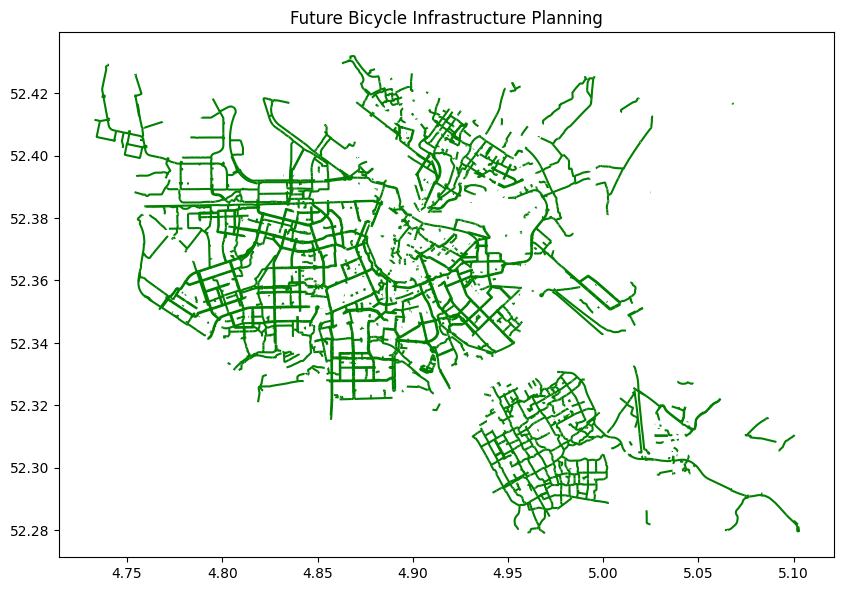

In [29]:
Future_planning = gpd.read_file('/content/future_planning.geojson')

fig, ax = plt.subplots(figsize=(10, 10))
Future_planning.plot(ax=ax, color='green', edgecolor='black')
ax.set_title('Future Bicycle Infrastructure Planning')
plt.show()

In [60]:
Future_planning.describe

<bound method NDFrame.describe of                   id             @id abandoned:railway access  \
0        way/4264947     way/4264947              None   None   
1        way/4270806     way/4270806              None   None   
2        way/4305753     way/4305753              None   None   
3        way/4363637     way/4363637              None   None   
4        way/4364612     way/4364612              None    yes   
...              ...             ...               ...    ...   
8440  way/1221746604  way/1221746604              None   None   
8441  way/1221781756  way/1221781756              None   None   
8442  way/1223327216  way/1223327216              None     no   
8443  way/1223327217  way/1223327217              None   None   
8444  way/1223327218  way/1223327218              None   None   

     access:conditional agricultural alt_name architect asphalt bicycle  ...  \
0                  None         None     None      None    None    None  ...   
1                  None  